In [1]:
from configs import API_KEY, DEFAULT_MODEL
import os
import openai
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
os.environ["OPENAI_API_KEY"] = API_KEY
openai.api_key = os.getenv('OPENAI_API_KEY')

In [3]:
class State(MessagesState):
    summary: str

state = State()

In [4]:
chat = ChatOpenAI(model='gpt-4',
                 seed = 365,
                 temperature = 0,
                 max_completion_tokens = 100)

In [5]:
def ask_question(state: State) -> State:
    print("\n--------------> Entering Ask Question Node:")
    question = "What is your question?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

def chatbot(state: State) -> State:
    print("\n--------------> Entering Chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    system_message = f"""
    Here is a quick summary of what's been discussed so far:
    {state.get("summary","")}
    Keep this in mind as you answer the next question.
    """
    
    response = chat.invoke([SystemMessage(system_message)] + state['messages'])
    response.pretty_print()
    return State(messages=[response])
    
def ask_another_question(state: State) -> State:
    print("\n--------------> Entering Ask Another Question Node:")
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    return State(messages=[AIMessage(question), HumanMessage(input())])

def summarize_and_delete_messages(state: State) -> State:
    print("\n--------------> Entering summarization Node:")
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f"""
    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    {state.get("summary","")}

    New Conversation:
    {new_conversation}
    """

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(i.id) for i in state["messages"][:]]
    
    return State(messages = remove_messages, summary = summary.content)

In [15]:
summarize_and_delete_messages(State(messages=[HumanMessage("who invented smartPhones?")]))


--------------> Entering trim_messages Node:

    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    

    New Conversation:
    human: who invented smartPhones?


    


{'messages': [RemoveMessage(content='', additional_kwargs={}, response_metadata={})],
 'summary': 'AI: The concept of smartphones was first introduced by IBM in 1992 with a device called Simon Personal Communicator. However, the first true smartphone as we know it today was introduced by Apple Inc. in 2007, known as the iPhone.'}

In [16]:
graph_ms = StateGraph(MessagesState)
graph_ms.add_node("ask_question", ask_question)
graph_ms.add_node("chatbot", chatbot)
# graph_ms.add_node("ask_another_question", ask_another_question)
graph_ms.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph_ms.add_edge(START, "ask_question")
graph_ms.add_edge("ask_question", "chatbot")
graph_ms.add_edge("chatbot", "summarize_and_delete_messages")
# graph_ms.add_conditional_edges(source = "ask_another_question", 
                            # path = routing_function,)
graph_ms.add_edge("summarize_and_delete_messages", END)

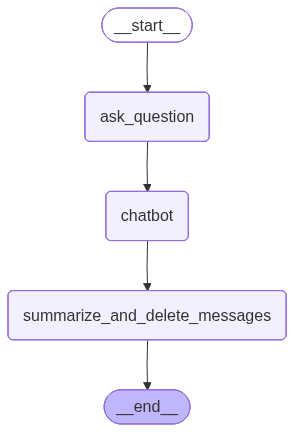

In [17]:
checkpointer = InMemorySaver()
graph_ms_compiled = graph_ms.compile(checkpointer)
graph_ms_compiled

In [18]:
config1 = {"configurable": {"thread_id": "1"}}

In [19]:
graph_ms_compiled.invoke(State(), config1)


--------------> Entering Ask Question Node:
What is your question?


 who is Brad Pitt?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who is Brad Pitt?
================================== Ai Message ==================================

Brad Pitt is an American actor and film producer. He was born on December 18, 1963, in Shawnee, Oklahoma. Pitt is recognized as one of the most influential and powerful people in the American entertainment industry. He has received multiple awards, including two Golden Globe Awards and an Academy Award for his acting, in addition to another Academy Award, a BAFTA Award, and a Primetime Emmy Award as a producer under his production company, Plan B Entertainment. Some of his most notable

--------------> Entering trim_messages Node:

    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeati

{'messages': []}

In [20]:
graph_ms_compiled.invoke(State(), config1)


--------------> Entering Ask Question Node:
What is your question?


 where was he born?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

where was he born?
================================== Ai Message ==================================

Brad Pitt was born in Shawnee, Oklahoma, United States.

--------------> Entering trim_messages Node:

    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    The AI provided information about Brad Pitt, detailing his career as an American actor and film producer. It mentioned his birth date and place, and highlighted his influence and power in the American entertainment industry. The AI also listed some of the awards he has received, including two Golden Globe Awards and an Academ

{'messages': []}

In [22]:
graph_ms_compiled.invoke(State(), config1)


--------------> Entering Ask Question Node:
What is your question?


 Which episode of friends did he appear?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Which episode of friends did he appear?
================================== Ai Message ==================================

Brad Pitt appeared in the eighth season of "Friends" in an episode titled "The One with the Rumor." He played the character Will Colbert, who was an old high school friend of Ross and Monica. This is the ninth episode of the season.

--------------> Entering trim_messages Node:

    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    The AI informed the user that it cannot provide real-time information or future predictions, and thus does not have information a

{'messages': []}

In [23]:
config2 = {"configurable": {"thread_id": "2"}}

In [25]:
graph_ms_compiled.invoke(State(), config2)


--------------> Entering Ask Question Node:
What is your question?


 When did he born?



--------------> Entering Chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

When did he born?
================================== Ai Message ==================================

I'm sorry, but I can't provide the information you're looking for because you didn't specify who you're asking about. Could you please provide more details?

--------------> Entering trim_messages Node:

    Update the ongoing summary by incorporating new lines of the conversation below.
    Build upon the previous summary rather than repeating it so that the result
    reflects the most recent context and developments.

    Previous summary:
    

    New Conversation:
    ai: What is your question?

human: When did he born?

ai: I'm sorry, but I can't provide the information you're looking for because you didn't specify who you're asking about. Could you please provid

{'messages': []}

In [29]:
graph_states = [i for i in graph_ms_compiled.get_state_history(config1)]

In [30]:
graph_states

[StateSnapshot(values={'messages': [], 'summary': "The user inquired about Brad Pitt's birth date, to which the AI responded that he was born on December 18, 1963."}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f1054eb-c3f2-6d63-8017-e8cd66cd2028'}}, metadata={'source': 'loop', 'step': 23, 'parents': {}}, created_at='2026-02-09T00:31:54.904099+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f1054eb-baff-6cb7-8016-a75462d220fa'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='87adaf08-54b2-4ed9-8ebb-ca0215efa135', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='When did he born?', additional_kwargs={}, response_metadata={}, id='296de14c-eae5-4758-8858-4e343a7de587'), AIMessage(content='Brad Pitt was born on December 18, 1963.', additional_kwargs={'refusal': None}, respons

In [32]:
for i in graph_states[::-1]:
    print(f"""Messages: {i.values["messages"]}
    Summary: {i.values.get("summary")}
    Next: {i.next}
    Metadata: {i.metadata["step"]}
    """)

Messages: []
    Summary: None
    Next: ('__start__',)
    Metadata: -1
    
Messages: []
    Summary: None
    Next: ('ask_question',)
    Metadata: 0
    
Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='ad2775ea-dd16-4dd8-86cd-cf3970866455', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='who is Brad Pitt?', additional_kwargs={}, response_metadata={}, id='f1eea83c-024f-40a5-9f7f-7cd5118f46b1')]
    Summary: None
    Next: ('chatbot',)
    Metadata: 1
    
Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='ad2775ea-dd16-4dd8-86cd-cf3970866455', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='who is Brad Pitt?', additional_kwargs={}, response_metadata={}, id='f1eea83c-024f-40a5-9f7f-7cd5118f46b1'), AIMessage(content='Brad Pitt is an American actor and film producer. He was born on December 18, 1963, in Shawnee, Oklahoma. Pitt is recognized as one of the 